In [464]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import os
import glob

In [465]:
torch.cuda.is_available()
device = torch.device("cuda")


# Load The Dataset

In [466]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, drop_last = True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, drop_last = True)

Files already downloaded and verified
Files already downloaded and verified


In [467]:
first_batch = next(iter(trainloader))

print(first_batch[0].size())
print(first_batch[1].size())

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [468]:
images = first_batch[0]
labels = first_batch[1]

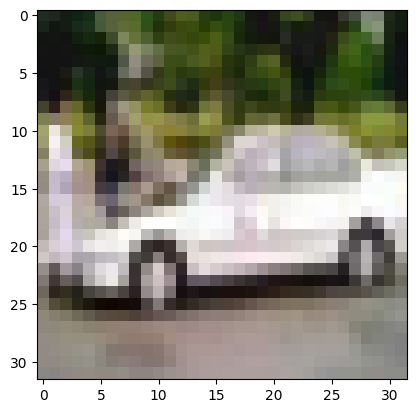

In [469]:
plt.imshow(np.transpose((images[0] + 1) /2, (1,2,0)))
plt.show()

# Design your own Network

In [470]:
class CustomNN(nn.Module):
    def __init__(self):
        super(CustomNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size = 3),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.fc_1 = nn.Linear(64 * 6 * 6, 512)
        nn.ReLU(inplace=True)
        self.fc_2 = nn.Linear(512, 128)
        nn.ReLU(inplace=True)
        self.fc_3 = nn.Linear(128, 10)
        nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 64 * 6 * 6)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x

In [471]:
model = CustomNN().to(device)
images = images.to(device)  
output = model(images)
print(output.size())

torch.Size([64, 10])


In [472]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    loss_per_epoch = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        '''for epoch in range(num_epochs):
        loss_per_epoch = 0
        for images, label in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()'''
        loss_per_epoch += loss
    print(f"Epoch {epoch+1}/{num_epochs}, loss_per_epoch: {loss_per_epoch}")

Epoch 1/10, Loss: 1.5079920652123329
Epoch 2/10, Loss: 1.1310234285805199
Epoch 3/10, Loss: 0.9442909972005251
Epoch 4/10, Loss: 0.8135031652511616
Epoch 5/10, Loss: 0.6928246796665363
Epoch 6/10, Loss: 0.5820221971916023
Epoch 7/10, Loss: 0.4764783378409057
Epoch 8/10, Loss: 0.3755279695197806
Epoch 9/10, Loss: 0.2862254568541401
Epoch 10/10, Loss: 0.21709288587071068


In [473]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        '''
        with torch.no_grad():
            for images, label in testloader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        '''
print(f"Test Accuracy: {correct/total}")

Test Accuracy: 0.6974158653846154
